In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from keras import backend as K
from keras import initializers
from keras.engine.topology import Layer
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.utils import CustomObjectScope
from tensorflow import matmul

%matplotlib inline

Using TensorFlow backend.


In [2]:
with open('data_final/aws_data/X_train.pkl', 'rb') as infile:
    X_train = pickle.load(infile)
    
with open('data_final/aws_data/X_val.pkl', 'rb') as infile:
    X_val = pickle.load(infile)

with open('data_final/aws_data/X_test.pkl', 'rb') as infile:
    X_test = pickle.load(infile)

with open('data_final/aws_data/y_train.pkl', 'rb') as infile:
    y_train = pickle.load(infile)
    
with open('data_final/aws_data/y_val.pkl', 'rb') as infile:
    y_val = pickle.load(infile)

with open('data_final/aws_data/y_test.pkl', 'rb') as infile:
    y_test = pickle.load(infile)

In [3]:
def recombine(array):
    '''
    Rejoins the lists of words in the articles pre-formatted for training into a single string.
    
    Returns: String containing all the words in an article that was pre-formatted.
    '''
    return [' '.join(' '.join(sent) for sent in array)][0]

In [4]:
data = X_val.apply(recombine)
data = data.append(X_train.apply(recombine))
labels = y_val.append(y_train)

In [5]:
sample_data = data.sample(20000)
sample_indices = sample_data.index
sample_labels = labels[sample_indices]

In [6]:
counter = CountVectorizer(decode_error='ignore', strip_accents='unicode', max_features=50000)
counter.fit(data)
sample_data_counts = counter.transform(sample_data)

In [7]:
Cs = list(np.logspace(-4, 1, num=11))
clf = LogisticRegressionCV(Cs=Cs, solver='sag', cv=5)
tfidf = TfidfTransformer()
tfidf.fit(data_counts)
lrcv = clf.fit(X=tfidf.transform(sample_data_counts), y=sample_labels)
lrcv.C_

array([ 3.16227766])

In [8]:
#  Since the best value determined for C was the greatest of the values tried, run again with larger values
np.random.seed(3)
Cs = list(np.linspace(1, 10, num=10))
clf = LogisticRegressionCV(Cs=Cs, solver='sag', cv=5)
lrcv = clf.fit(X=tfidf.fit_transform(sample_data_counts), y=sample_labels)
lrcv.C_

array([ 4.])

In [9]:
Cs = list(np.linspace(1, 5, num=5))
ratios = list(np.linspace(0, 1, num=5))
clf = LogisticRegressionCV(Cs=Cs, l1_ratios=ratios, penalty='elasticnet', solver='saga', cv=5, max_iter=300)
lrcv = clf.fit(X=tfidf.transform(sample_data_counts), y=sample_labels)
lrcv.C_, lrcv.l1_ratio_

/Users/vince/anaconda/envs/thinkful/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(array([ 4.]), array([ 0.]))

For logistic regression using either the sag or sag solver, a C value of 4 and the L2 penalty produce the optimal results.

In [10]:
test_strings = X_test.apply(recombine)
X_test_counts = counter.transform(test_strings)

In [13]:
data_counts = counter.transform(data)
lr = LogisticRegression(C=4.0, solver='sag', random_state=77, max_iter=300)
lr.fit(X=tfidf.transform(data_counts), y=labels)
lr.score(X=tfidf.transform(X_test_counts), y=y_test)

0.86896874999999996

In [14]:
lr = LogisticRegression(C=4.0, solver='saga', random_state=77, max_iter=300)
lr.fit(X=tfidf.transform(data_counts), y=labels)
lr.score(X=tfidf.transform(X_test_counts), y=y_test)

0.86896093750000003

In [15]:
counter = CountVectorizer(decode_error='ignore', strip_accents='unicode', max_features=150000)
counter.fit(data)
data_counts = counter.fit_transform(data)
X_test_counts = counter.transform(test_strings)

In [17]:
lr = LogisticRegression(C=4.0, solver='sag', random_state=77, max_iter=300)
lr.fit(X=tfidf.fit_transform(data_counts), y=labels)
lr.score(X=tfidf.transform(X_test_counts), y=y_test)

0.87283593749999999

Logistic regression after tuning for the value of C and either the L1 (only possiblefor the saga solver) or L2 penalty and with a 150,000-word vocabulary did slightly better than the simple cross-validation-fit accuracy of about 0.845 obtained as the benchmark in the data exploration notebook using a vocabulary of less than 5,000 words. Nonetheless, this is an impressive result compared to the HAN model trained using a cyclic learning rate, which achieved a slightly lower validation accuracy. The HAN model trained for 16 hours compared with 5 minutes or so for the logistic regression classifier. The HAN models using the adam optimizer, however, did obtain significantly higher validation scores just over 0.90. But these trained models need to be run on the test set.

In [19]:
max_words = 30  # max num words processed for each sentence
max_sentences = 30  # max num sentences processed for each article 
max_vocab = 150000
attention_dim = 100
batch_size = 64
words_file = 'data_final/words.pkl'
saved_model = 'models/adam-150-200-100/model.4.hdf5'

In [20]:
with open(words_file, 'rb') as infile:
    words = pickle.load(infile)
word_index = {}
for ix, (word, _) in enumerate(words.most_common(max_vocab)):
    word_index[word] = ix + 1

In [21]:
def create_data_matrix(data, max_sentences=max_sentences, max_words=max_words, max_vocab=max_vocab,
                      word_index=word_index):
    data_matrix = np.zeros((len(data), max_sentences, max_words), dtype='int32')
    for i, article in enumerate(data):
        for j, sentence in enumerate(article):
            if j == max_sentences:
                break
            k = 0
            for word in sentence:
                if k == max_words:
                    break
                ix = word_index.get(word.lower())
                if ix is not None and ix < max_vocab:
                    data_matrix[i, j, k] = ix
                k = k + 1
    return data_matrix

In [22]:
X_test_keras = create_data_matrix(X_test)
y_test_keras = np.asarray(to_categorical(y_test))

In [23]:
class HierarchicalAttentionNetwork(Layer):
    ''''''
    def __init__(self, **kwargs):
        self.init_weights = initializers.get('glorot_normal')
        self.init_bias = initializers.get('zeros')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super().__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init_weights((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init_bias((self.attention_dim,)))
        self.u = K.variable(self.init_weights((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super().build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):        
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))
        
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [24]:
with CustomObjectScope({'HierarchicalAttentionNetwork': HierarchicalAttentionNetwork}):
            model = load_model(saved_model)

In [26]:
#  Save logistic regression model artifacts and garbage collect to free up memory
with open('models/logistic/counter.pkl', 'wb') as outfile:
    pickle.dump(counter, outfile)
with open('models/logistic/tfidf.pkl', 'wb') as outfile:
    pickle.dump(tfidf, outfile)
with open('models/logistic/lr.pkl', 'wb') as outfile:
    pickle.dump(lr, outfile)

In [27]:
import gc
data = None
data_counts = None
sample_data = None
sample_data_counts = None
X_train = None
X_val = None
gc.collect()

4

In [29]:
model.evaluate(x=X_test_keras, y=y_test_keras, batch_size=batch_size)

128000/128000 [==============================] - 2970s 23ms/step


[0.22986735509708522, 0.91568749999999999]

In [67]:
keras_probs = model.predict(x=X_test_keras, batch_size=batch_size)

In [68]:
lr_probs = lr.predict_proba(X=tfidf.transform(X_test_counts))

In [89]:
probs = pd.DataFrame.from_dict({'keras_0': [x[0] for x in keras_probs], 'keras_1': [x[1] for x in keras_probs],
                                'lr_0': [x[0] for x in lr_probs], 'lr_1': [x[1] for x in lr_probs]})

In [96]:
preds = pd.DataFrame.from_dict({'keras': [1 if x >= 0.5 else 0 for x in probs['keras_1']],
                                'lr': [1 if x >= 0.5 else 0 for x in probs['lr_1']]})

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds['keras'])

array([[58986,  5014],
       [ 5778, 58222]])

In [100]:
confusion_matrix(y_test, preds['lr'])

array([[55524,  8476],
       [ 7801, 56199]])

The confusion matrices show that the HAN model is slightly better at predicting the reliable articles (y=0) than it is at predicting the unreliable articles (y=1), the specificity is better than the sensitivity, while the opposite is true for the logistic regression model. Aggregating the results could improve performance.

In [104]:
aggregated = (probs['keras_1'] + probs['lr_1']) / 2
aggregated = [1 if x >= 0.5 else 0 for x in aggregated]
confusion_matrix(y_test, aggregated)

array([[59055,  4945],
       [ 5047, 58953]])

Aggregation did boost the overall accuracy to 0.922 from the HAN model's 0.916. It also balances the results, with the number of true positives differing from the number of true negatives by only 102 out of just over 118,000 correctly classified articles. The best results, then, are obtained from an ensemble of the HAN and logistic regression models.

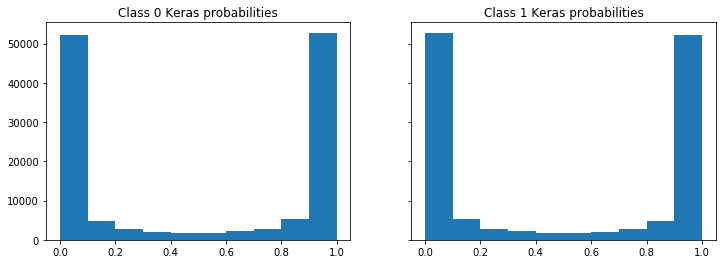

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(probs['keras_0'])
ax1.set_title('Class 0 Keras probabilities')
ax2.hist(probs['keras_1'])
ax2.set_title('Class 1 Keras probabilities')

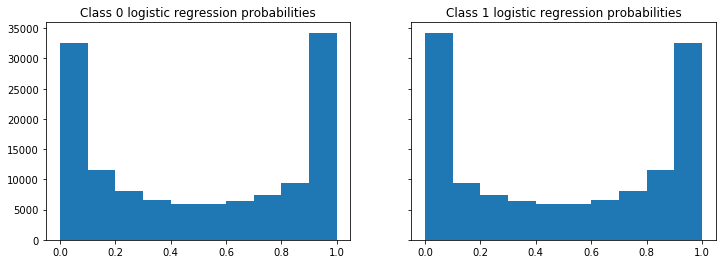

In [111]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(probs['lr_0'])
ax1.set_title('Class 0 logistic regression probabilities')
ax2.hist(probs['lr_1'])
ax2.set_title('Class 1 logistic regression probabilities')

The HAN model made much more confident predictions, the vast quantity in the 0-0.1 or .9-1.0 ranges. The LR predictions were much more spread out, but like the HAN, the fewest were in the  0.4-0.6 range. Is this where most of the wrong predictions fell?

In [135]:
probs['actual'] = y_test.values

In [147]:
keras_false_pos = probs['keras_1'].where((probs['actual'] == 0) & (probs['keras_1'] >= 0.5), np.nan)
keras_false_neg = probs['keras_1'].where((probs['actual'] == 1) & (probs['keras_0'] >= 0.5), np.nan)

In [148]:
keras_false_pos.dropna(inplace=True)
keras_false_neg.dropna(inplace=True)
len(keras_false_pos), len(keras_false_neg)

(5014, 5778)

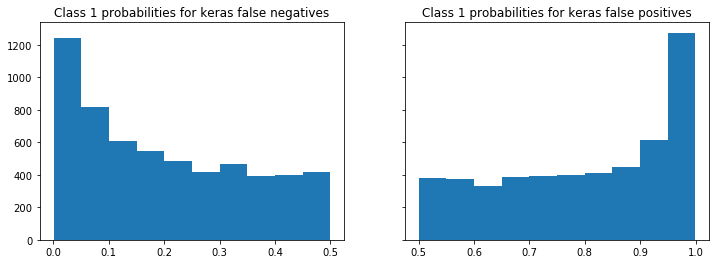

In [149]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(keras_false_neg)
ax1.set_title('Class 1 probabilities for keras false negatives')
ax2.hist(keras_false_pos)
ax2.set_title('Class 1 probabilities for keras false positives')

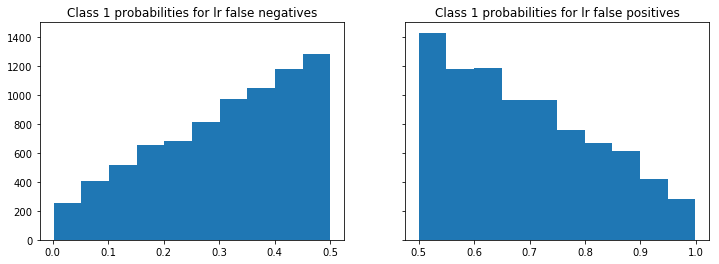

In [150]:
lr_false_pos = probs['lr_1'].where((probs['actual'] == 0) & (probs['lr_1'] >= 0.5), np.nan)
lr_false_neg = probs['lr_1'].where((probs['actual'] == 1) & (probs['lr_0'] >= 0.5), np.nan)
lr_false_pos.dropna(inplace=True)
lr_false_neg.dropna(inplace=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(lr_false_neg)
ax1.set_title('Class 1 probabilities for lr false negatives')
ax2.hist(lr_false_pos)
ax2.set_title('Class 1 probabilities for lr false positives')

Interesingly, the HAN model tends to make its wrong predictions confidently, about half of them being assigned probabilities of less than 0.2 in the correct class, while the logistic regression model is more apt to make wrong predictions near the decision threshold.

In [162]:
probs['agg_0'] = (probs['keras_0'] + probs['lr_0']) / 2
probs['agg_1'] = (probs['keras_1'] + probs['lr_1']) / 2

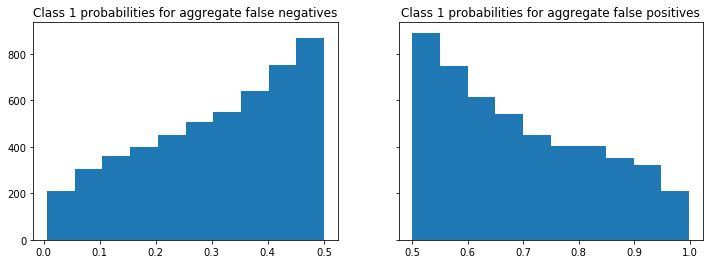

In [164]:
agg_false_pos = probs['agg_1'].where((probs['actual'] == 0) & (probs['agg_1'] >= 0.5), np.nan)
agg_false_neg = probs['agg_1'].where((probs['actual'] == 1) & (probs['agg_0'] >= 0.5), np.nan)
agg_false_pos.dropna(inplace=True)
agg_false_neg.dropna(inplace=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.hist(agg_false_neg)
ax1.set_title('Class 1 probabilities for aggregate false negatives')
ax2.hist(agg_false_pos)
ax2.set_title('Class 1 probabilities for aggregate false positives')

The aggregate model's wrong predictions are even more concentrated near the decision boundary than the lr model and do not show the high-confidence spiking of the HAN model. It will give the most accurate predictive probabilities. Further analysis of the wrong predictions involves recreating the final dataset before the train/test split, which discarded the domain info and reset the index.

In [151]:
y_test.head()

271171    0
548613    1
446254    1
549425    1
553032    1
Name: label, dtype: int64

In [152]:
with open('data_final/reliable_final.pkl', 'rb') as infile:
    reliable = pickle.load(infile)
with open('data_final/unreliable_final.pkl', 'rb') as infile:
    unreliable = pickle.load(infile)
reliable['label'] = 0
unreliable['label'] = 1
data = reliable.append(unreliable).reset_index()

In [160]:
from sklearn.model_selection import train_test_split
cols = ['id', 'domain', 'content']
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['label'], test_size=0.2,
                                                    random_state=77, stratify=data['label'])

In [165]:
X_test.head().index  # Make sure this aligns with the y_test indices

Int64Index([271171, 548613, 446254, 549425, 553032], dtype='int64')

In [178]:
probs.index = y_test.index

In [184]:
false_pos_indices = probs[(probs['actual'] == 0) & (probs['agg_1'] >= 0.5)].index
false_neg_indices = probs[(probs['actual'] == 1) & (probs['agg_0'] >= 0.5)].index

In [195]:
false_pos_domains = pd.DataFrame(X_test.loc[false_pos_indices]['domain'], columns=['domain'])
false_neg_domains = pd.DataFrame(X_test.loc[false_neg_indices]['domain'], columns=['domain'])

In [203]:
false_pos_counts = false_pos_domains.groupby(['domain']).size().reset_index(name='wrong')
false_neg_counts = false_neg_domains.groupby(['domain']).size().reset_index(name='wrong')

In [204]:
reliable_domains = reliable['domain'].unique()
unreliable_domains = unreliable['domain'].unique()

In [207]:
reliable_test_counts = X_test[X_test['domain'].isin(reliable_domains)].groupby('domain').size().reset_index(name='total')

In [214]:
list(reliable_test_counts['domain']) == list(false_pos_counts['domain'])

True

In [217]:
reliable_test_counts['wrong'] = false_pos_counts['wrong']

In [219]:
reliable_test_counts['ratio'] = reliable_test_counts['wrong'] / reliable_test_counts['total']

In [221]:
reliable_test_counts.sort_values(by='ratio', ascending=False)

,domain,total,wrong,ratio
25,weeklystandard.com,6043,1229,0.203376
9,foreignpolicyjournal.com,457,92,0.201313
13,mintpressnews.com,4549,898,0.197406
5,buzzfeed.com,173,26,0.150289
10,heritage.org,1420,144,0.101408
21,theatlantic.com,81,8,0.098765
15,nbcnews.com,2262,203,0.089744
24,washingtonpost.com,1753,131,0.074729
11,jacobinmag.com,1454,106,0.072902
6,buzzfeednews.com,349,25,0.071633


In [222]:
unreliable_test_counts = X_test[X_test['domain'].isin(unreliable_domains)].groupby('domain').size().reset_index(name='total')
list(unreliable_test_counts['domain']) == list(false_neg_counts['domain'])

False

Some sources identified as unreliable had no false negatives.

In [269]:
false_neg_domain_names = false_neg_domains['domain'].unique()

full_false_neg_counts = [list(false_neg_counts[false_neg_counts['domain'] == domain]['wrong'])[0] \
                         if domain in false_neg_domain_names else 0 \
                         for domain in unreliable_test_counts['domain'].values]

In [271]:
unreliable_test_counts['wrong'] = full_false_neg_counts
unreliable_test_counts['ratio'] = unreliable_test_counts['wrong'] / unreliable_test_counts['total']
unreliable_test_counts.sort_values(by='ratio', ascending=False)

,domain,total,wrong,ratio
40,goneleft.com,2,1,0.500000
64,platosguns.com,3,1,0.333333
42,heartland.org,55,14,0.254545
44,ihr.org,48,11,0.229167
14,commondreams.org,1265,274,0.216601
81,thefifthcolumnnews.com,1080,233,0.215741
2,alternet.org,1707,345,0.202109
56,off-guardian.org,51,9,0.176471
54,newcoldwar.org,6,1,0.166667
19,counterpunch.org,665,109,0.163910


In [272]:
unreliable_test_counts[unreliable_test_counts['domain'] == 'dailykos.com']

,domain,total,wrong,ratio
22,dailykos.com,8292,338,0.040762
